In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data_loader import *

The aim of this notebook is to look if there is a correlation between the cosine similarity of the categories of source-target and a measure of difficulty (path length, duration and rating).

# Clean data

In [2]:
categories = read_categories()
categories['category'] = categories['category'].str.replace('^subject\.', '', regex=True)
categories.head()

,article,category,level_1,level_2,level_3
0,Áedán mac Gabráin,History.British_History.British_History_1500_a...,History,British_History,British_History_1500_and_before_including_Roma...
1,Áedán mac Gabráin,People.Historical_figures,People,Historical_figures,None
2,Åland,Countries,Countries,None,None
3,Åland,Geography.European_Geography.European_Countries,Geography,European_Geography,European_Countries
4,Édouard Manet,People.Artists,People,Artists,None


In [3]:
# Drop duplicates, keeping the longest description
categories['category_length'] = categories['category'].str.len()
categories_sorted = categories.sort_values(by=['article', 'category_length'], ascending=[True, False])
categories_unique = categories_sorted.drop_duplicates(subset='article', keep='first').reset_index(drop=True)
categories_unique = categories_unique.drop(columns=['category_length', 'level_1', 'level_2', 'level_3'])
categories_unique.head()

,article,category
0,1 Ceres,Science.Physics.Space_Astronomy
1,10th century,History.General_history
2,11th century,History.General_history
3,12th century,History.General_history
4,13th century,History.General_history


In [4]:
paths_finished=read_finished_paths()
paths_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,14th century;15th century;16th century;Pacific...,NaN
1,3824310e536af032,2012-08-12 06:36:52,88,14th century;Europe;Africa;Atlantic slave trad...,3.0
2,415612e93584d30e,2012-10-03 21:10:40,138,14th century;Niger;Nigeria;British Empire;Slav...,NaN
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,14th century;Renaissance;Ancient Greece;Greece,NaN
4,015245d773376aab,2013-04-23 15:27:08,175,14th century;Italy;Roman Catholic Church;HIV;R...,3.0


In [5]:
tasks_finished = pd.DataFrame()

tasks_finished['source'] = paths_finished['path'].apply(lambda x: x.split(';')[0])
tasks_finished['target'] = paths_finished['path'].apply(lambda x: x.split(';')[-1])
tasks_finished['path_length'] = paths_finished['path'].apply(lambda x: len(x.split(';')))
tasks_finished['duration'] =  paths_finished['durationInSec']
tasks_finished['rating'] =  paths_finished['rating']

tasks_finished.head()

,source,target,path_length,duration,rating
0,14th century,African slave trade,9,166,NaN
1,14th century,African slave trade,5,88,3.0
2,14th century,African slave trade,8,138,NaN
3,14th century,Greece,4,37,NaN
4,14th century,John F. Kennedy,7,175,3.0


In [6]:
#Map the article to the corresponding category
category_mapping = dict(zip(categories_unique['article'], categories_unique['category']))
tasks_finished['source'] = tasks_finished['source'].map(category_mapping)
tasks_finished['target'] = tasks_finished['target'].map(category_mapping)

tasks_finished=tasks_finished.dropna(subset=['source','target']) # 6 articles do not have a category

tasks_finished.head()

,source,target,path_length,duration,rating
0,History.General_history,History.General_history,9,166,NaN
1,History.General_history,History.General_history,5,88,3.0
2,History.General_history,History.General_history,8,138,NaN
3,History.General_history,Geography.European_Geography.European_Countries,4,37,NaN
4,History.General_history,People.USA_Presidents,7,175,3.0


In [7]:
import re

def clean_text(text):
    # Split by '.' or '_'
    words = re.split(r'[._]', text)
    
    # Remove unwanted word 'general' and other unwanted terms
    words = [word for word in words if word.lower() != 'general']
    
    # Remove duplicate consecutive words
    words = [words[i] for i in range(len(words)) if i == 0 or words[i].lower() != words[i-1].lower()]
    
    # Recombine the cleaned words
    cleaned_text = ' '.join(words)
    
    return cleaned_text

tasks_finished['source_cleaned'] = tasks_finished['source'].apply(clean_text)
tasks_finished['target_cleaned'] = tasks_finished['target'].apply(clean_text)

tasks_finished.head()

,source,target,path_length,duration,rating,source_cleaned,target_cleaned
0,History.General_history,History.General_history,9,166,NaN,History,History
1,History.General_history,History.General_history,5,88,3.0,History,History
2,History.General_history,History.General_history,8,138,NaN,History,History
3,History.General_history,Geography.European_Geography.European_Countries,4,37,NaN,History,Geography European Geography European Countries
4,History.General_history,People.USA_Presidents,7,175,3.0,History,People USA Presidents


# Embeddings and cosine similarity

In [8]:
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from FlagEmbedding import BGEM3FlagModel

unique_categories = pd.unique(tasks_finished[['source_cleaned', 'target_cleaned']].values.ravel('K'))

model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)
print("Embedding model initialized. GPU usage depends on model's internal settings.")

# Embed categories
categorie_embeddings = {}
for categorie in tqdm(unique_categories, desc="Embedding Unique categories"):
    categorie_embeddings[categorie] = model.encode(categorie)['dense_vecs']

# Map embeddings back to the source and target columns
tasks_finished['source_embedding'] = tasks_finished['source_cleaned'].map(categorie_embeddings)
tasks_finished['target_embedding'] = tasks_finished['target_cleaned'].map(categorie_embeddings)

# Calculate cosine similarity
tasks_finished['cosine_similarity'] = [cosine_similarity([src], [tgt])[0, 0] for src, tgt in tqdm(zip(tasks_finished['source_embedding'], tasks_finished['target_embedding']), desc="Calculating Similarities")]



Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

Embedding model initialized. GPU usage depends on model's internal settings.


Embedding Unique Articles: 100%|██████████| 127/127 [00:56<00:00,  2.27it/s]
Calculating Similarities: 51249it [00:05, 8814.09it/s]


Even after cleaning text, some cosine similarities do not seem appropriate, as index 6 here, where chemistry is closer to history than presidents

In [9]:
tasks_finished = tasks_finished[tasks_finished['source_cleaned'] != tasks_finished['target_cleaned']]
tasks_finished.head()

,source,target,path_length,duration,rating,source_cleaned,target_cleaned,source_embedding,target_embedding,cosine_similarity
3,History.General_history,Geography.European_Geography.European_Countries,4,37,NaN,History,Geography European Geography European Countries,"[0.007504, 0.03906, -0.01357, 0.04858, -0.0293...","[-0.003508, 0.03427, 0.00745, 0.01318, -0.0266...",0.383699
4,History.General_history,People.USA_Presidents,7,175,3.0,History,People USA Presidents,"[0.007504, 0.03906, -0.01357, 0.04858, -0.0293...","[-0.04953, 0.002855, -0.03763, -0.009995, -0.0...",0.375225
5,History.General_history,People.USA_Presidents,6,110,NaN,History,People USA Presidents,"[0.007504, 0.03906, -0.01357, 0.04858, -0.0293...","[-0.04953, 0.002855, -0.03763, -0.009995, -0.0...",0.375225
6,History.General_history,Science.Chemistry.General_Chemistry,4,112,2.0,History,Science Chemistry,"[0.007504, 0.03906, -0.01357, 0.04858, -0.0293...","[-0.0604, 0.03003, 0.00403, -0.04156, -0.02362...",0.450834
7,History.General_history,Geography.Climate_and_the_Weather,6,139,1.0,History,Geography Climate and the Weather,"[0.007504, 0.03906, -0.01357, 0.04858, -0.0293...","[-0.04703, 0.04214, -0.02815, -0.02356, -0.027...",0.478972


# Correlations

Pearson correlation: PearsonRResult(statistic=-0.04794518959397445, pvalue=5.263245917201676e-27)
Spearman correlation: SignificanceResult(statistic=-0.04669692921522157, pvalue=1.0622142309227614e-25)


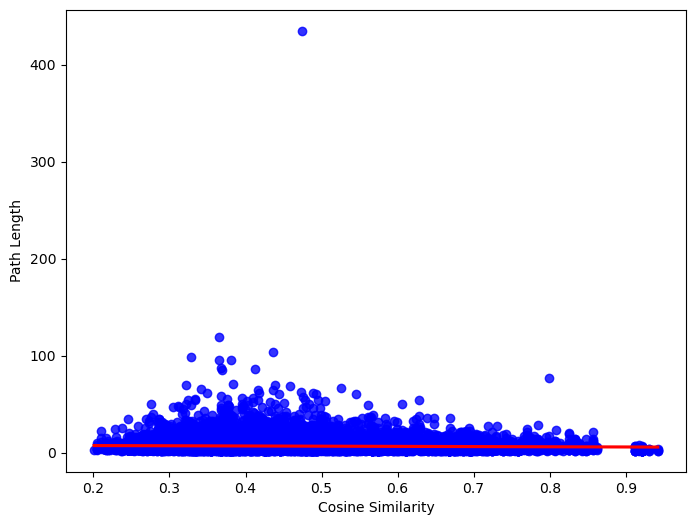

In [31]:
from scipy import stats
import seaborn as sns
p = stats.pearsonr(tasks_finished["cosine_similarity"], tasks_finished["path_length"])
s = stats.spearmanr(tasks_finished["cosine_similarity"], tasks_finished["path_length"])
print(f"Pearson correlation: {p}")
print(f"Spearman correlation: {s}")

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x="cosine_similarity", y="path_length", data=tasks_finished, scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.xlabel('Cosine Similarity')
plt.ylabel('Path Length')
plt.show()

In [21]:
tasks_finished.describe()

,path_length,duration,rating,cosine_similarity
count,50319.000000,50319.000000,27940.000000,50319.000000
mean,6.806097,159.898527,2.278203,0.442493
std,4.669942,363.511813,1.105426,0.109239
min,2.000000,1.000000,1.000000,0.200885
25%,5.000000,62.000000,1.000000,0.367324
50%,6.000000,108.000000,2.000000,0.424695
75%,8.000000,185.000000,3.000000,0.488514
max,435.000000,35091.000000,5.000000,0.942024


Let's see what happen if we zoom into shorts path (75% of total number)

Pearson correlation: PearsonRResult(statistic=-0.0699678308557518, pvalue=2.126346842637081e-45)
Spearman correlation: SignificanceResult(statistic=-0.03904561463656995, pvalue=3.153893582760545e-15)


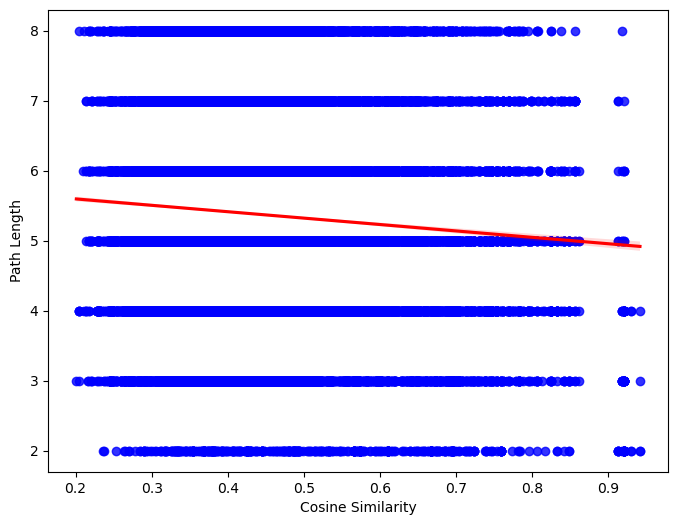

In [34]:
tasks_finished_shorts = tasks_finished[tasks_finished['path_length'] < 9]

p = stats.pearsonr(tasks_finished_shorts["cosine_similarity"], tasks_finished_shorts["path_length"])
s = stats.spearmanr(tasks_finished_shorts["cosine_similarity"], tasks_finished_shorts["path_length"])
print(f"Pearson correlation: {p}")
print(f"Spearman correlation: {s}")

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x="cosine_similarity", y="path_length", data=tasks_finished_shorts, scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.xlabel('Cosine Similarity')
plt.ylabel('Path Length')
plt.show()

Pearson correlation: PearsonRResult(statistic=-0.02941385465040493, pvalue=4.129659776521791e-11)
Spearman correlation: SignificanceResult(statistic=-0.069212775217703, pvalue=1.7474410407683685e-54)


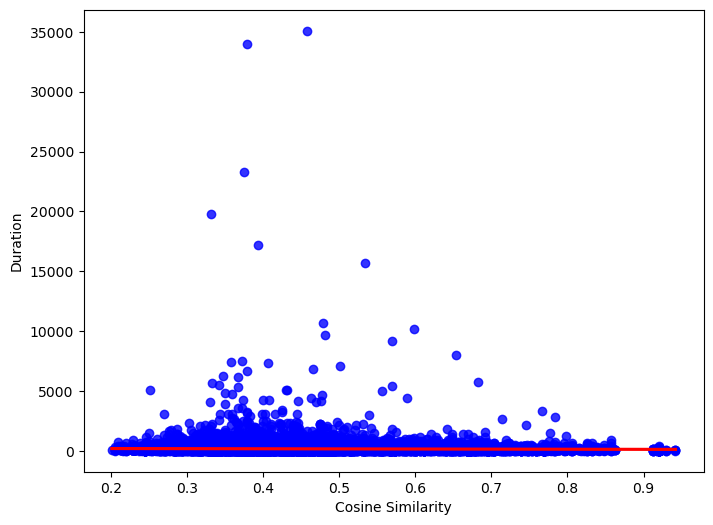

In [33]:
p = stats.pearsonr(tasks_finished["cosine_similarity"], tasks_finished["duration"])
s = stats.spearmanr(tasks_finished["cosine_similarity"], tasks_finished["duration"])
print(f"Pearson correlation: {p}")
print(f"Spearman correlation: {s}")

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x="cosine_similarity", y="duration", data=tasks_finished, scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.xlabel('Cosine Similarity')
plt.ylabel('Duration')
plt.show()

Let's see what happen when we zoom into faster runs (less than 185s, 75% of total runs)

Pearson correlation: PearsonRResult(statistic=-0.08199210139912642, pvalue=1.7761151350638902e-57)
Spearman correlation: SignificanceResult(statistic=-0.05969700951192308, pvalue=3.070274159840189e-31)


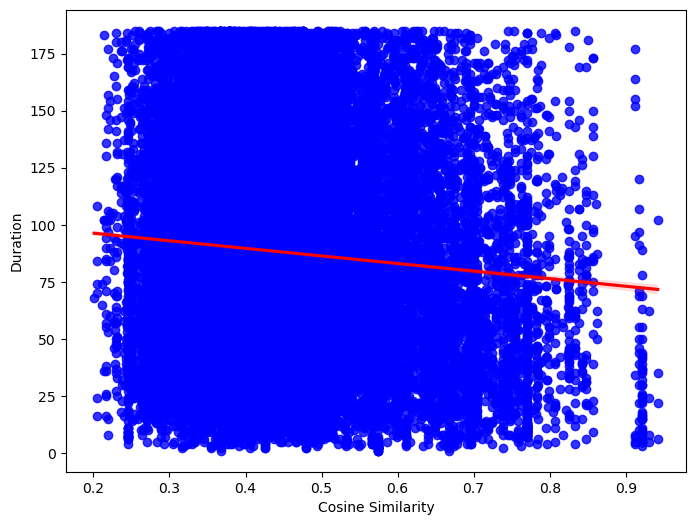

In [35]:
tasks_finished_shorts = tasks_finished[tasks_finished['duration'] <= 185]

p = stats.pearsonr(tasks_finished_shorts["cosine_similarity"], tasks_finished_shorts["duration"])
s = stats.spearmanr(tasks_finished_shorts["cosine_similarity"], tasks_finished_shorts["duration"])
print(f"Pearson correlation: {p}")
print(f"Spearman correlation: {s}")

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x="cosine_similarity", y="duration", data=tasks_finished_shorts, scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.xlabel('Cosine Similarity')
plt.ylabel('Duration')
plt.show()

Pearson correlation: PearsonRResult(statistic=-0.05211889220184924, pvalue=2.8480258986602212e-18)
Spearman correlation: SignificanceResult(statistic=-0.04324685606910375, pvalue=4.763341526897141e-13)


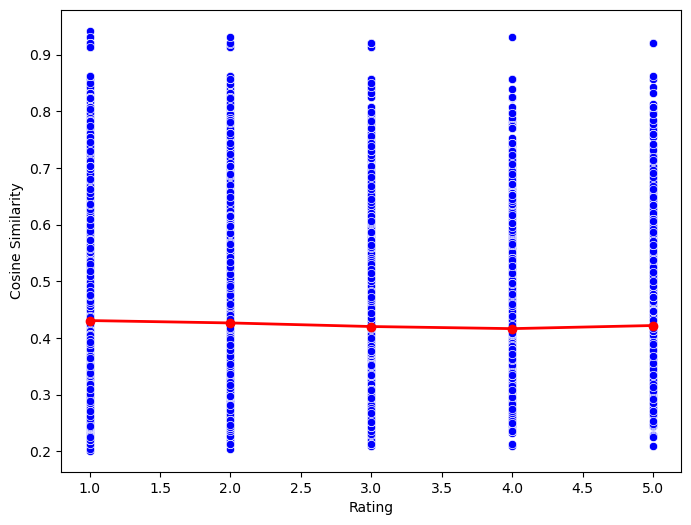

,rating,cosine_similarity
0,1.0,0.430579
1,2.0,0.426373
2,3.0,0.420037
3,4.0,0.416328
4,5.0,0.421837


In [36]:
tasks_finished_rating=tasks_finished.dropna(subset=['rating'])

p = stats.pearsonr(tasks_finished_rating["cosine_similarity"], tasks_finished_rating["rating"])
s = stats.spearmanr(tasks_finished_rating["cosine_similarity"], tasks_finished_rating["rating"])
print(f"Pearson correlation: {p}")
print(f"Spearman correlation: {s}")

median_ratings = tasks_finished.groupby('rating')['cosine_similarity'].median().reset_index()

plt.figure(figsize=(8, 6))
sns.scatterplot(x="rating", y="cosine_similarity", data=tasks_finished, color='blue')
plt.plot(median_ratings['rating'], median_ratings['cosine_similarity'], color='red', lw=2, marker='o')
plt.xlabel('Rating')
plt.ylabel('Cosine Similarity')
plt.show()

median_ratings

### What motivates the rating?

Pearson correlation: PearsonRResult(statistic=0.2530794944669966, pvalue=0.0)
Spearman correlation: SignificanceResult(statistic=0.5446815629388275, pvalue=0.0)


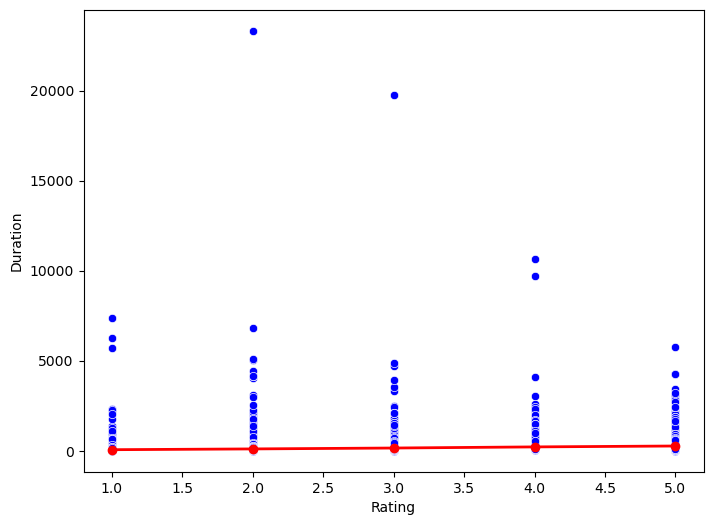

In [37]:
p = stats.pearsonr(tasks_finished_rating["duration"], tasks_finished_rating["rating"])
s = stats.spearmanr(tasks_finished_rating["duration"], tasks_finished_rating["rating"])
print(f"Pearson correlation: {p}")
print(f"Spearman correlation: {s}")

median_ratings = tasks_finished.groupby('rating')['duration'].median().reset_index()

plt.figure(figsize=(8, 6))
sns.scatterplot(x="rating", y="duration", data=tasks_finished, color='blue')
plt.plot(median_ratings['rating'], median_ratings['duration'], color='red', lw=2, marker='o')
plt.xlabel('Rating')
plt.ylabel('Duration')
plt.show()

Pearson correlation: PearsonRResult(statistic=0.3924637161788049, pvalue=0.0)
Spearman correlation: SignificanceResult(statistic=0.4352578396778478, pvalue=0.0)


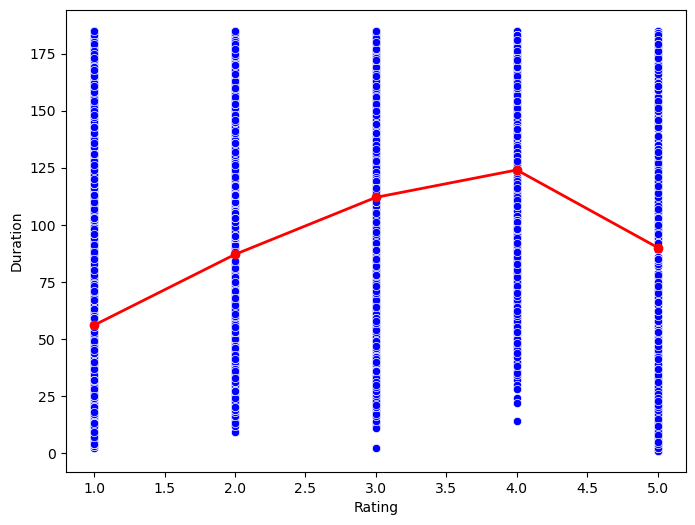

In [38]:
tasks_finished_shorts_rating = tasks_finished_rating[tasks_finished_rating['duration'] <= 185]

p = stats.pearsonr(tasks_finished_shorts_rating["duration"], tasks_finished_shorts_rating["rating"])
s = stats.spearmanr(tasks_finished_shorts_rating["duration"], tasks_finished_shorts_rating["rating"])
print(f"Pearson correlation: {p}")
print(f"Spearman correlation: {s}")

median_ratings = tasks_finished_shorts.groupby('rating')['duration'].median().reset_index()

plt.figure(figsize=(8, 6))
sns.scatterplot(x="rating", y="duration", data=tasks_finished_shorts, color='blue')
plt.plot(median_ratings['rating'], median_ratings['duration'], color='red', lw=2, marker='o')
plt.xlabel('Rating')
plt.ylabel('Duration')
plt.show()

Pearson correlation: PearsonRResult(statistic=0.4050267362096235, pvalue=0.0)
Spearman correlation: SignificanceResult(statistic=0.5542786716864333, pvalue=0.0)


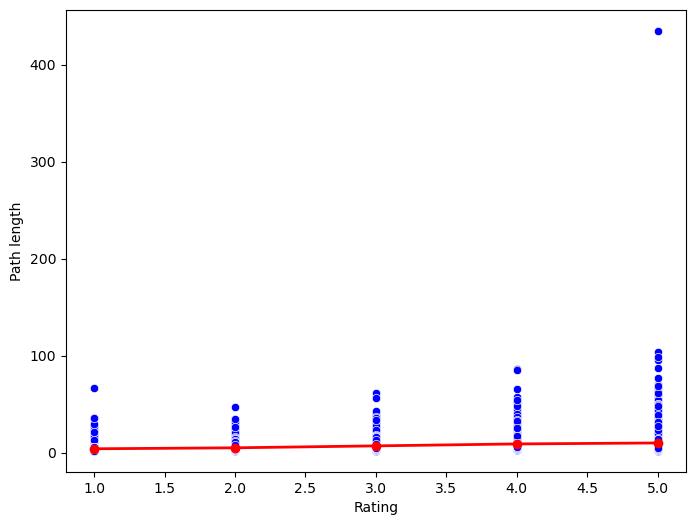

In [39]:
p = stats.pearsonr(tasks_finished_rating["path_length"], tasks_finished_rating["rating"])
s = stats.spearmanr(tasks_finished_rating["path_length"], tasks_finished_rating["rating"])
print(f"Pearson correlation: {p}")
print(f"Spearman correlation: {s}")

median_ratings = tasks_finished.groupby('rating')['path_length'].median().reset_index()

plt.figure(figsize=(8, 6))
sns.scatterplot(x="rating", y="path_length", data=tasks_finished, color='blue')
plt.plot(median_ratings['rating'], median_ratings['path_length'], color='red', lw=2, marker='o')
plt.xlabel('Rating')
plt.ylabel('Path length')
plt.show()

Pearson correlation: PearsonRResult(statistic=0.41997905298539034, pvalue=0.0)
Spearman correlation: SignificanceResult(statistic=0.45617106743727553, pvalue=0.0)


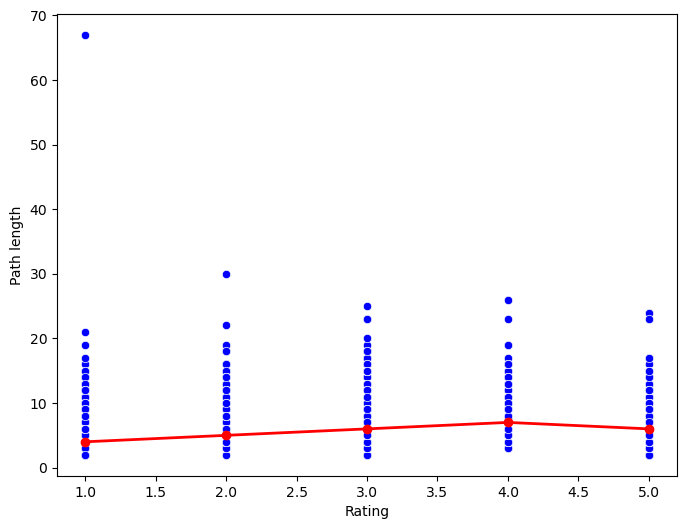

In [40]:
tasks_finished_shorts_rating = tasks_finished_rating[tasks_finished_rating['path_length'] <= 8]

p = stats.pearsonr(tasks_finished_shorts_rating["path_length"], tasks_finished_shorts_rating["rating"])
s = stats.spearmanr(tasks_finished_shorts_rating["path_length"], tasks_finished_shorts_rating["rating"])
print(f"Pearson correlation: {p}")
print(f"Spearman correlation: {s}")

median_ratings = tasks_finished_shorts.groupby('rating')['path_length'].median().reset_index()

plt.figure(figsize=(8, 6))
sns.scatterplot(x="rating", y="path_length", data=tasks_finished_shorts, color='blue')
plt.plot(median_ratings['rating'], median_ratings['path_length'], color='red', lw=2, marker='o')
plt.xlabel('Rating')
plt.ylabel('Path length')
plt.show()

Generally rating is increasing with duration and path length. The rating 5 depends less from these factors when taking into account shorts paths and run durations.

# Difficult target categories

In [41]:
target_medians = tasks_finished.groupby('target').agg({
    'path_length': 'median',
    'duration': 'median',
    'rating': 'median'  
}).reset_index()

target_medians

,target,path_length,duration,rating
0,Art.Art,6.0,133.0,2.0
1,Business_Studies.Business,7.0,137.0,3.0
2,Business_Studies.Companies,6.0,139.0,2.0
3,Business_Studies.Currency,5.0,61.0,2.0
4,Business_Studies.Economics,6.0,109.0,2.0
...,...,...,...,...
122,Science.Physics.Electricity_and_Electronics,6.0,126.0,2.0
123,Science.Physics.General_Physics,6.0,102.5,2.0
124,Science.Physics.Space_Astronomy,6.0,103.0,2.0
125,Science.Physics.Space_transport,7.0,141.0,2.0


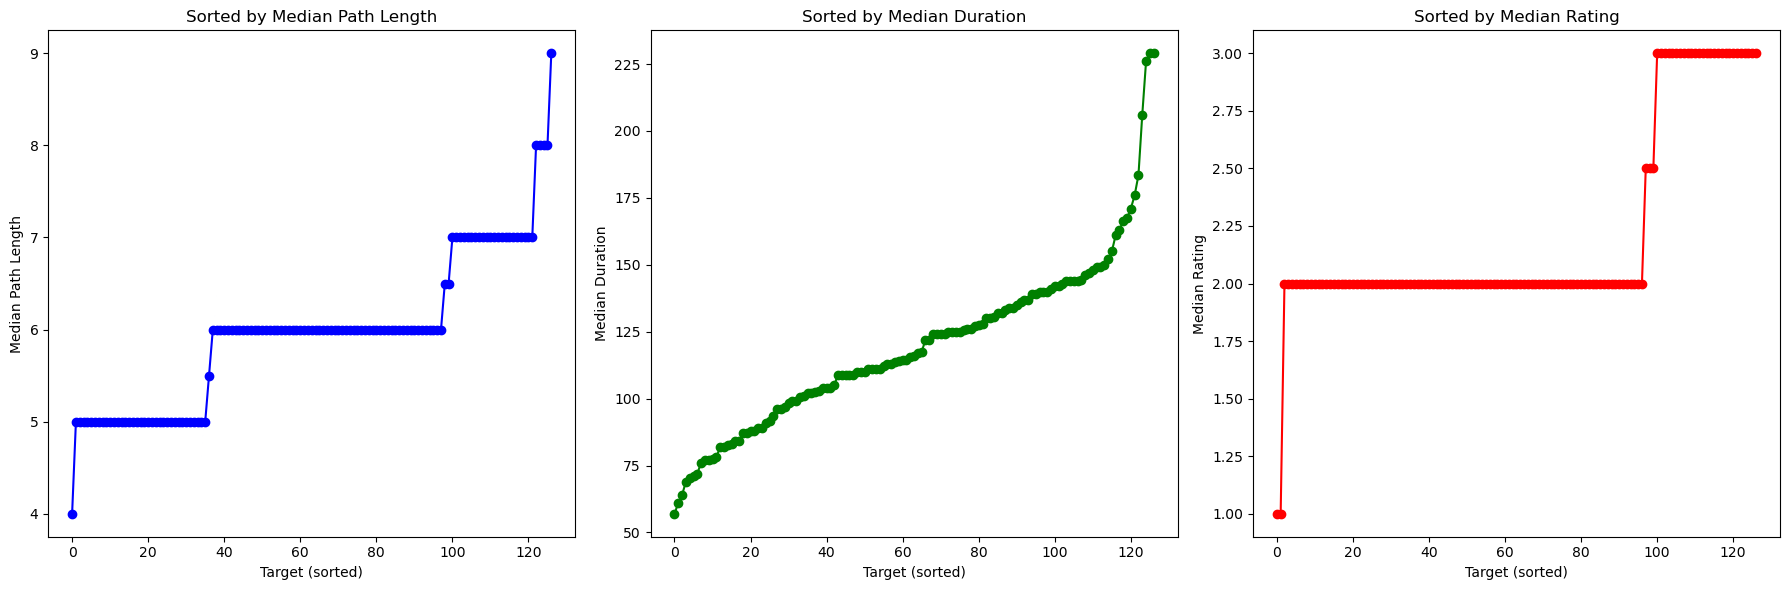

In [42]:
sorted_by_path_length = target_medians.sort_values(by='path_length').reset_index(drop=True)
sorted_by_duration = target_medians.sort_values(by='duration').reset_index(drop=True)
sorted_by_rating = target_medians.sort_values(by='rating').dropna().reset_index(drop=True)  # Drop NaNs for rating

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(sorted_by_path_length['path_length'], marker='o', color='blue')
axes[0].set_title('Sorted by Median Path Length')
axes[0].set_xlabel('Target (sorted)')
axes[0].set_ylabel('Median Path Length')

axes[1].plot(sorted_by_duration['duration'], marker='o', color='green')
axes[1].set_title('Sorted by Median Duration')
axes[1].set_xlabel('Target (sorted)')
axes[1].set_ylabel('Median Duration')

axes[2].plot(sorted_by_rating['rating'], marker='o', color='red')
axes[2].set_title('Sorted by Median Rating')
axes[2].set_xlabel('Target (sorted)')
axes[2].set_ylabel('Median Rating')

plt.tight_layout()
plt.show()

In [49]:
# Sort by each metric and find the 120th value as the threshold
path_length_threshold = target_medians.sort_values(by='path_length', ascending=True).iloc[119]['path_length']
duration_threshold = target_medians.sort_values(by='duration', ascending=True).iloc[119]['duration']
rating_threshold = target_medians.dropna(subset=['rating']).sort_values(by='rating', ascending=True).iloc[119]['rating']

# Filter targets that meet or exceed each threshold
top_path_length_targets = target_medians[target_medians['path_length'] >= path_length_threshold]['target'].tolist()
top_duration_targets = target_medians[target_medians['duration'] >= duration_threshold]['target'].tolist()
top_rating_targets = target_medians[target_medians['rating'] >= rating_threshold]['target'].tolist()

# Convert lists to sets for easier comparison
top_path_length_set = set(top_path_length_targets)
top_duration_set = set(top_duration_targets)
top_rating_set = set(top_rating_targets)

# Find common targets across the sets
common_in_path_and_duration = top_path_length_set & top_duration_set
common_in_path_and_rating = top_path_length_set & top_rating_set
common_in_duration_and_rating = top_duration_set & top_rating_set
common_in_all_three = top_path_length_set & top_duration_set & top_rating_set

print("Targets in both path_length and duration top thresholds:", common_in_path_and_duration)
print("Targets in both path_length and rating top thresholds:", common_in_path_and_rating)
print("Targets in both duration and rating top thresholds:", common_in_duration_and_rating)
print("Targets in all three top thresholds:", common_in_all_three)


Targets in both path_length and duration top thresholds: {'Science.Biology.Dinosaurs', 'Everyday_life.Television', 'Religion.Myths', 'Everyday_life.Cartoons', 'IT.Cryptography', 'People.Actors_models_and_celebrities', 'Everyday_life.Games'}
Targets in both path_length and rating top thresholds: {'People.Chemists', 'Everyday_life.Food_and_agriculture', 'History.British_History.British_History_1500_and_before_including_Roman_Britain', 'People.Computing_People', 'Science.Biology.Insects_Reptiles_and_Fish', 'Science.Biology.Birds', 'Science.Biology.Dinosaurs', 'Everyday_life.Games', 'Everyday_life.Television', 'Business_Studies.Business', 'Religion.Myths', 'Everyday_life.Cartoons', 'Everyday_life.Computer_and_Video_games', 'People.Actors_models_and_celebrities', 'IT.Websites_and_the_Internet', 'IT.Computer_Programming', 'Everyday_life.Films', 'Science.Biology.Health_and_medicine'}
Targets in both duration and rating top thresholds: {'Science.Biology.Dinosaurs', 'Everyday_life.Television', 